In [ ]:
!pip uninstall -y torch torchvision torchaudio
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Found existing installation: torch 2.5.1+cu121
Uninstalling torch-2.5.1+cu121:
  Successfully uninstalled torch-2.5.1+cu121
Found existing installation: torchvision 0.20.1+cu121
Uninstalling torchvision-0.20.1+cu121:
  Successfully uninstalled torchvision-0.20.1+cu121
Found existing installation: torchaudio 2.5.1+cu121
Uninstalling torchaudio-2.5.1+cu121:
  Successfully uninstalled torchaudio-2.5.1+cu121
Looking in indexes: https://download.pytorch.org/whl/cu121
  Using cached https://download.pytorch.org/whl/cu121/torch-2.5.1%2Bcu121-cp311-cp311-linux_x86_64.whl (780.5 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchvision-0.20.1%2Bcu121-cp311-cp311-linux_x86_64.whl (7.3 MB)
  Using cached https://download.pytorch.org/whl/cu121/torchaudio-2.5.1%2Bcu121-cp311-cp311-linux_x86_64.whl (3.4 MB)


In [ ]:
!pip install "fastapi[all]" langgraph langchain_google_genai pyngrok pillow "diffusers>=0.27.0" "transformers>=4.38.0" accelerate "invisible_watermark>=0.2.0" -q

In [ ]:
!git clone https://github.com/ace-step/ACE-Step.git
%cd ACE-Step
!pip install -e .
%cd ..

fatal: destination path 'ACE-Step' already exists and is not an empty directory.
/content/ACE-Step
Obtaining file:///content/ACE-Step
  Preparing metadata (setup.py) ... done
  Attempting uninstall: ace_step
    Found existing installation: ace_step 0.2.0
    Uninstalling ace_step-0.2.0:
      Successfully uninstalled ace_step-0.2.0
  Running setup.py develop for ace_step
/content


In [ ]:
import os
from google.colab import userdata
from huggingface_hub import login

project_root = "/content/text-to-music-image"
src_dir = os.path.join(project_root, "src")
nodes_dir = os.path.join(src_dir, "nodes")
outputs_dir = os.path.join(project_root, "outputs")
images_dir = os.path.join(outputs_dir, "images")
music_dir = os.path.join(outputs_dir, "music")
temp_dir = os.path.join(project_root, "temp_downloads")

os.makedirs(nodes_dir, exist_ok=True)
os.makedirs(images_dir, exist_ok=True)
os.makedirs(music_dir, exist_ok=True)
os.makedirs(temp_dir, exist_ok=True)
%cd {project_root}

print(f"Project Root: {project_root}")

os.environ["GEMINI_API_KEY"] = userdata.get('GEMINI_API_KEY')

hf_token = userdata.get('HF_TOKEN')
login(token=hf_token)

/content/text-to-music-image
Project Root: /content/text-to-music-image


In [ ]:
%%writefile src/state.py
from typing import TypedDict, Optional, Dict, List

class GenerationState(TypedDict):
    narrative: str
    characters: List[str]

    previous_image_path: Optional[str]
    previous_image_style: Optional[str]

    image_prompt: Optional[str]
    image_style_description: Optional[str]

    music_theory: Optional[Dict]
    music_prompt: Optional[str]

    image_path: Optional[str]
    music_path: Optional[str]

    error: Optional[str]
    audio_duration: Optional[float]
    guidance_scale: Optional[float]
    omega_scale: Optional[float]
    infer_step: Optional[float]

Writing src/state.py


In [ ]:
%%writefile src/models.py
from pydantic import BaseModel, Field
from typing import List, Literal

class MusicTheory(BaseModel):
    mood: str = Field(description="The dominant mood or emotion of the narrative.")
    genre: str = Field(description="The most fitting musical genre for the narrative.")
    tempo: Literal["very slow", "slow", "medium", "fast", "very fast"] = Field(description="The appropriate tempo for the music.")
    key_instruments: List[str] = Field(description="A list of 2-4 key instruments.")
    detailed_prompt: str = Field(description="A detailed, comma-separated prompt for the music AI.")

class ArtConcept(BaseModel):
    image_prompt: str = Field(description="A highly detailed, synthesized prompt for the SDXL image model. It should include the scene, characters, items, lighting, and camera angle.")
    style_description: str = Field(description="A description of the artistic style used in the prompt (e.g., 'dark fantasy oil painting', 'vibrant anime cel-shading', 'photorealistic'). This will be used to ensure consistency in the next image.")

Writing src/models.py


In [ ]:
%%writefile src/nodes/art_director.py
import os
import logging
from langchain_google_genai import ChatGoogleGenerativeAI
import sys
sys.path.append('/content/text-to-music-image')
from src.state import GenerationState
from src.models import ArtConcept

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

_llm_cache = None
def get_llm():
    global _llm_cache
    if _llm_cache is None:
        _llm_cache = ChatGoogleGenerativeAI(model="gemini-1.5-flash", google_api_key=os.environ.get("GEMINI_API_KEY"))
    return _llm_cache

def art_director_node(state: GenerationState) -> dict:
    logging.info("Art Director is composing the scene...")

    narrative = state.get("narrative")
    characters = state.get("characters")
    has_previous_image = state.get("previous_image_path") is not None
    previous_style = state.get("previous_image_style", "epic dark fantasy oil painting, detailed brushstrokes")

    character_str = ", ".join(characters) if characters else "No specific characters mentioned."

    llm_structured = get_llm().with_structured_output(ArtConcept)

    prompt_template = f"""
    You are an expert Art Director. Your task is to create a detailed prompt for an image AI model to generate visuals for a game.

    **Artistic Goal:** Create a new image that is a logical evolution of the previous one (if any), reflecting the new narrative.

    **INPUTS:**
    - **Previous Image Context:** {"The AI will see the previous image. Its style is described as: '" + previous_style + "'. Your prompt must align with this." if has_previous_image else "This is the very first image."}
    - **New Narrative:** {narrative}
    - **Characters in New Scene:** {character_str}

    **Your Directives:**
    1.  **Synthesize Inputs:** Combine the narrative, characters, and items into a single, cohesive scene description.
    2.  **Write a Powerful Prompt:** Create the `image_prompt`. It should describe the scene in full detail, including lighting, camera focus, and character actions.
    3.  **Enforce Style:** Use keywords from the previous style description to maintain visual cohesion. If this is the first image, establish a strong, clear style.
    4.  **Describe the Resulting Style:** Provide a concise `style_description` for the next cycle.

    **!! CRITICAL CONSTRAINT !!**
    The final `image_prompt` MUST be concise and kept under **75 tokens**. Focus on the most impactful visual elements. Do not write a long paragraph.

    Provide your output in the requested JSON format.
    """

    try:
        response: ArtConcept = llm_structured.invoke(prompt_template)
        logging.info(f"Art Director generated prompt: {response.image_prompt}")
        logging.info("Art Director has finalized the concept.")
        return {
            "image_prompt": response.image_prompt,
            "image_style_description": response.style_description
        }
    except Exception as e:
        logging.error(f"Art Director failed: {e}", exc_info=True)
        return {"error": f"Art Director failed: {e}"}

Writing src/nodes/art_director.py


In [ ]:
%%writefile src/nodes/image_generator.py
import torch
from diffusers import AutoPipelineForImage2Image
from PIL import Image
import os
import uuid
import logging
import sys
sys.path.append('/content/text-to-music-image')
from src.state import GenerationState

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
_pipeline_cache = None

def get_image_pipeline():
    global _pipeline_cache
    if _pipeline_cache is None:
        logging.info("Initializing Stable Diffusion XL Img2Img Pipeline...")
        pipe = AutoPipelineForImage2Image.from_pretrained(
            "stabilityai/stable-diffusion-3.5-large",
            torch_dtype=torch.bfloat16,
            variant="fp16",
            use_safetensors=True
        )
        pipe.to("cuda")
        pipe.transformer = torch.compile(pipe.transformer, mode="max-autotune")
        pipe.vae = torch.compile(pipe.vae, mode="max-autotune")
        _pipeline_cache = pipe
        logging.info("SDXL Img2Img Pipeline loaded.")
    return _pipeline_cache

def image_generator_node(state: GenerationState) -> dict:
    prompt = state.get("image_prompt")
    if not prompt:
        return {"error": "Image prompt is missing from the Art Director."}

    previous_image_path = state.get("previous_image_path")

    try:
        pipe = get_image_pipeline()

        if previous_image_path and os.path.exists(previous_image_path):
            logging.info(f"Using previous image as reference: {previous_image_path}")
            init_image = Image.open(previous_image_path).convert("RGB")
            strength = 0.65
            num_steps = 20
        else:
            logging.info("No previous image found. Generating a new image from scratch.")
            init_image = Image.new('RGB', (512, 512), 'black')
            strength = 1.0
            num_steps = 25

        image = pipe(
            prompt=prompt,
            image=init_image,
            num_inference_steps=num_steps,
            strength=strength,
            guidance_scale=8.0,
        ).images[0]

        images_dir = "/content/text-to-music-image/outputs/images"
        filename = f"image_{uuid.uuid4().hex[:8]}.png"
        image_path = os.path.join(images_dir, filename)
        image.save(image_path)
        logging.info(f"Image saved to: {image_path}")
        return {"image_path": image_path}
    except Exception as e:
        logging.error(f"Image generation failed: {e}", exc_info=True)
        return {"error": f"Image generation failed: {e}"}

Writing src/nodes/image_generator.py


In [ ]:
%%writefile src/nodes/music_theorist.py
import os
import logging
from langchain_google_genai import ChatGoogleGenerativeAI
import sys
sys.path.append('/content/text-to-music-image')
from src.state import GenerationState
from src.models import MusicTheory

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def get_llm():
    from src.nodes.art_director import get_llm as get_shared_llm
    return get_shared_llm()

def music_theorist_node(state: GenerationState) -> dict:
    narrative = state.get("narrative")
    if not narrative:
        return {"error": "Narrative is missing for music theory."}

    logging.info("Analyzing narrative for music concept...")
    llm_structured = get_llm().with_structured_output(MusicTheory)

    prompt_template = f"""
    You are an expert game composer. Analyze the provided game narrative and create a musical concept that fits its spirit.
    Consider the mood, setting, and tension.

    **Narrative:**
    {narrative}

    Provide your analysis in the requested JSON format (mood, genre, tempo, key_instruments, detailed_prompt).
    """
    try:
        response: MusicTheory = llm_structured.invoke(prompt_template)
        logging.info("Music theory generated.")
        return {"music_theory": response.model_dump(), "music_prompt": response.detailed_prompt}
    except Exception as e:
        return {"error": f"Music theory generation failed: {e}"}

Writing src/nodes/music_theorist.py


In [ ]:
%%writefile src/nodes/music_generator.py
import os
import uuid
import torch
import logging
from acestep.pipeline_ace_step import ACEStepPipeline
import sys
sys.path.append('/content/text-to-music-image')
from src.state import GenerationState

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
_music_pipeline_cache = None

def get_music_pipeline():
    global _music_pipeline_cache
    if _music_pipeline_cache is None:
        logging.info("Initializing ACE-Step Music Pipeline...")
        os.environ["CUDA_VISIBLE_DEVICES"] = "0"
        pipe = ACEStepPipeline(
            model_id="ace-step/ACE-Step",
            dtype="bfloat16",
            torch_compile=True
        )
        _music_pipeline_cache = pipe
        logging.info("ACE-Step Music Pipeline initialized.")
    return _music_pipeline_cache

def music_generator_node(state: GenerationState) -> dict:
    music_prompt = state.get("music_prompt")
    if not music_prompt:
        return {"error": "Music prompt is missing for generation."}

    try:
        logging.info(f"Generating music with prompt: '{music_prompt}'")
        music_pipe = get_music_pipeline()

        music_dir = "/content/text-to-music-image/outputs/music"
        filename = f"music_{uuid.uuid4().hex[:8]}.wav"
        music_path = os.path.join(music_dir, filename)

        output_paths = music_pipe(
            prompt=music_prompt,
            lyrics="",
            audio_duration=30.0,
            guidance_scale=12.0,
            infer_step=30,
            save_path=music_path
        )

        if not output_paths or not isinstance(output_paths, list) or not output_paths[0]:
             raise ValueError("ACE-Step pipeline returned an empty or invalid result.")

        logging.info(f"Music saved to: {output_paths[0]}")
        return {"music_path": output_paths[0]}

    except Exception as e:
        logging.error(f"Music generation pipeline failed: {e}", exc_info=True)
        return {"error": f"Music generation failed: {str(e)}"}

Writing src/nodes/music_generator.py


In [ ]:
%%writefile src/graph.py
from langgraph.graph import StateGraph, END, START
from src.state import GenerationState

from src.nodes.art_director import art_director_node
from src.nodes.image_generator import image_generator_node
from src.nodes.music_theorist import music_theorist_node
from src.nodes.music_generator import music_generator_node

def create_generation_graph():
    workflow = StateGraph(GenerationState)

    workflow.add_node("art_director", art_director_node)
    workflow.add_node("image_generator", image_generator_node)
    workflow.add_node("music_theorist", music_theorist_node)
    workflow.add_node("music_generator", music_generator_node)

    workflow.add_edge(START, "art_director")
    workflow.add_edge(START, "music_theorist")
    workflow.add_edge("art_director", "image_generator")
    workflow.add_edge("music_theorist", "music_generator")
    workflow.add_edge("image_generator", END)
    workflow.add_edge("music_generator", END)

    app_graph = workflow.compile()
    return app_graph

Writing src/graph.py


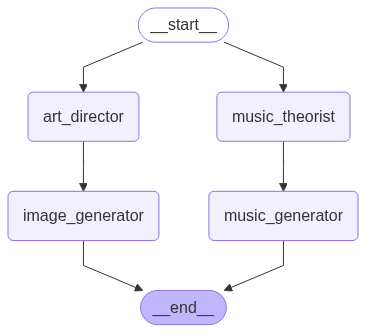

In [ ]:
from IPython.display import Image, display
from src.graph import create_generation_graph

app_graph = create_generation_graph()

data = app_graph.get_graph().draw_mermaid_png()

display(Image(data))

In [ ]:
%%writefile api.py
from fastapi import FastAPI, HTTPException
from fastapi.staticfiles import StaticFiles
from pydantic import BaseModel
import os
import logging
from typing import List, Optional
import uuid
import asyncio
import httpx

from src.nodes.image_generator import get_image_pipeline
from src.nodes.music_generator import get_music_pipeline

import sys
sys.path.append('/content/text-to-music-image')
from src.graph import create_generation_graph
from src.state import GenerationState

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

def warmup_models():
    logging.info("Thread: Initializing and compiling image pipeline...")
    get_image_pipeline()
    logging.info("Thread: Image pipeline ready.")

    logging.info("Thread: Initializing and warming up music pipeline...")
    music_pipe = get_music_pipeline()
    _ = music_pipe(
        prompt="warmup",
        lyrics="",
        audio_duration=1.0,
        infer_step=1,
        save_path=os.path.join("/content/text-to-music-image/temp_downloads", "warmup.wav")
    )
    logging.info("Thread: Music pipeline ready.")

async def lifespan(app: FastAPI):
    logging.info("Application starting up...")
    logging.info("Scheduling model warmup in a background thread...")
    warmup_task = asyncio.to_thread(warmup_models)
    await warmup_task

    logging.info("Models are pre-loaded, pre-warmed, and ready. Server is fully started.")
    yield
    logging.info("Application shutting down.")

app = FastAPI(
    title="Text to Music & Image API",
    description="Generates semantically consistent images and adaptive music from game state.",
    lifespan=lifespan
)

outputs_path = "/content/text-to-music-image/outputs"
temp_path = "/content/text-to-music-image/temp_downloads"
app.mount("/outputs", StaticFiles(directory=outputs_path), name="outputs")

class GenerationRequest(BaseModel):
    narrative: str
    characters: List[str]
    previous_image_url: Optional[str] = None
    previous_image_style: Optional[str] = None

class GenerationResponse(BaseModel):
    image_url: str
    music_url: str
    new_image_style: str

generation_graph = create_generation_graph()

async def download_image(url: str, save_path: str) -> Optional[str]:
    if not url: return None
    try:
        logging.info(f"Asynchronously downloading from: {url}")
        async with httpx.AsyncClient() as client:
            response = await client.get(url, follow_redirects=True, timeout=30.0)
            response.raise_for_status()
            with open(save_path, 'wb') as f:
                f.write(response.content)
        logging.info(f"Downloaded previous image to {save_path}")
        return save_path
    except httpx.RequestError as e:
        logging.error(f"Failed to download image from {url}: {e}")
        return None

@app.get("/")
def read_root(): return {"message": "Welcome to the Text to Music & Image API."}

@app.post("/generate", response_model=GenerationResponse)
async def generate_assets(request: GenerationRequest):
    logging.info("Generation request received.")
    public_url = os.environ.get("NGROK_PUBLIC_URL")
    if not public_url:
        raise HTTPException(status_code=500, detail="NGROK_PUBLIC_URL not found.")

    downloaded_image_path = None
    if request.previous_image_url:
        temp_filename = f"prev_{uuid.uuid4().hex[:8]}.png"
        save_to = os.path.join(temp_path, temp_filename)
        downloaded_image_path = await download_image(request.previous_image_url, save_to)

    initial_state = {
        "narrative": request.narrative,
        "characters": request.characters,
        "previous_image_path": downloaded_image_path,
        "previous_image_style": request.previous_image_style
    }
    try:
        final_state = await generation_graph.ainvoke(initial_state)

        if final_state.get("error"): raise HTTPException(status_code=500, detail=f"Generation failed: {final_state['error']}")

        image_path = final_state.get("image_path")
        music_path = final_state.get("music_path")
        new_style = final_state.get("image_style_description")

        if not all([image_path, music_path, new_style]):
            raise HTTPException(status_code=500, detail="Pipeline did not produce all required assets.")

        image_url = f"{public_url}/outputs/images/{os.path.basename(image_path)}"
        music_url = f"{public_url}/outputs/music/{os.path.basename(music_path)}"

        return GenerationResponse(image_url=image_url, music_url=music_url, new_image_style=new_style)
    except Exception as e:
        logging.error(f"Error in /generate endpoint: {e}", exc_info=True)
        raise HTTPException(status_code=500, detail=str(e))

Writing api.py


In [ ]:
!fuser -k 8000/tcp 2>/dev/null || true

from pyngrok import ngrok
import time
from google.colab import userdata

ngrok_auth_token = userdata.get('NGROK_AUTH_TOKEN')
ngrok.set_auth_token(ngrok_auth_token)

public_url = ngrok.connect(8000)
print(f"🔗 Public URL: {public_url}")

os.environ['NGROK_PUBLIC_URL'] = public_url.public_url

!nohup uvicorn api:app --host 0.0.0.0 --port 8000 > api.log 2>&1 &

  3385🔗 Public URL: NgrokTunnel: "https://a564a680702b.ngrok-free.app" -> "http://localhost:8000"


In [ ]:
!cat api.log

2025-07-25 12:59:06.449257: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753448346.472372   13354 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753448346.479301   13354 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
INFO:     Started server process [13354]
INFO:     Waiting for application startup.

A mixture of fp16 and non-fp16 filenames will be loaded.
Loaded fp16 filenames:
[text_encoder_3/model.fp16-00002-of-00002.safetensors, text_encoder_3/model.safetensors.index.fp16.json, text_encoder_3/model.fp16-00001-of-00002.safetensors, text_encoder_2/model.fp16.safetensors, text_encoder/model.fp16.safetensors]
Loaded non-fp16 filenames:
[transform